In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torch.utils.data import sampler

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cuda')

In [65]:
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])

aug_transform = T.Compose([
                T.ToTensor(),                
                T.RandomHorizontalFlip(p=0.5),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

NUM_TRAIN = 49000

ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=aug_transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

Files already downloaded and verified
Files already downloaded and verified


mean: 0.05
std: 1.26
max: 2.75
min: -2.43


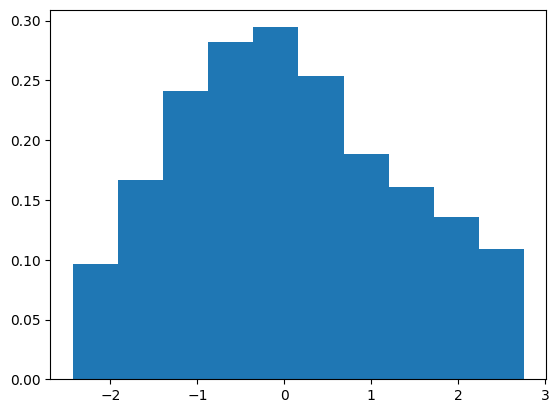

In [4]:
x, _ = next(iter(dl_train))
x = x.view(-1)
print(f"mean: {x.mean():.2f}")
print(f"std: {x.std():.2f}")
print(f"max: {x.max():.2f}")
print(f"min: {x.min():.2f}")

# hy, hx = torch.histogram(x, density=True)
# plt.plot(hx[:-1].detach(), hy.detach())
plt.hist(x, density=True);

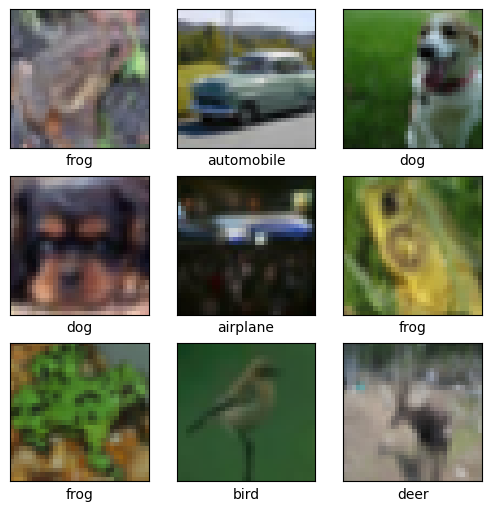

In [63]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                ax.set_xlabel(ds_train.classes[yh])

                if yh != y:
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

## Model

In [52]:

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, max_pool=True):
        super().__init__()
        
        if max_pool:
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.layers = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.BatchNorm2d(out_channels),
            )
        
    def forward(self, x):
        return self.layers(x)        
        


class CNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            Block(in_channels=3, out_channels=64,  max_pool=False),   # 32
            Block(in_channels=64, out_channels=128),   # 16
            Block(in_channels=128, out_channels=256),  # 8           
            Block(in_channels=256, out_channels=512),  # 4
            Block(in_channels=512, out_channels=512, max_pool=False),  # 4
            
            nn.Flatten(),
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(1024, 10),
        )

        for layer in self.layers:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")
                nn.init.zeros_(layer.bias)

        nn.init.xavier_normal_(self.layers[-1].weight)
        nn.init.zeros_(self.layers[-1].bias)


    def forward(self, x):
        return self.layers(x)


model = CNN()
print(f"parameter count: {sum([p.numel() for p in model.parameters()]):,}")

parameter count: 18,857,418


## Sanity Check

Initial loss check

In [ ]:
model = CNN()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("chance:", -torch.tensor(1/10).log().item())
print("loss:", loss.item())

chance: 2.3025851249694824
loss: 3.2331621646881104


Check if model has the capacity of overfit a small batch

In [ ]:
model = CNN()

xb, yb = next(iter(dl_train))
y = model(xb)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
xb, yb = next(iter(dl_train))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    print(f"{loss.item():.4f}")

    if loss.item() < 1e-5:
        break

KeyboardInterrupt: 

Activation distribution check

In [ ]:
model = CNN()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

plt.figure(figsize=(20, 4))
legends = []
for i, h in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, cut-off %.2f' % (i, h.mean(), h.std(), (h <= 0).to(dtype=torch.float).mean()))
    hy, hx = torch.histogram(h, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

In [ ]:
h1 = model.h[1].view(64, -1).detach().numpy()
h = h1[:, 1000:2000]
plt.figure(figsize=(10, 10))
plt.imshow(h)

h1.mean(), h1.std()

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
layers = [m for m in model.children() if "Conv" in str(m) or "Linear" in str(m)]

for i, m in enumerate(layers):
    t = m.weight.grad
    print('%d %s: mean %+.4f, std %.4f, zero: %.4f%%' % (i, str(m)[0:4], t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i}: {str(m)}')

plt.legend(legends);
plt.title('gradient distribution');

## Utility

In [7]:
@torch.no_grad()
def eval_split(split, model, sample_size=None):
    model.eval()
    dl = splits[split]

    num_correct = 0
    num_sample = 0
    lossi = []
    i = 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

        i += len(xb)
        if sample_size and i >= sample_size:
            break

    accuracy = float(num_correct) / num_sample
    loss = torch.tensor(lossi).mean().item()
    model.train()

    return loss, accuracy

## Hyper-parameter Search

In [ ]:
def try_model(lr, weight_decay):
    model = CNN()
    model = model.to(device=device)
    model.train()

    dl = splits["train"]
    epoch = 1
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    i = 0;
    for _ in range(epoch):
        for xb, yb in dl:
            xb = xb.to(device=device, dtype=dtype)
            yb = yb.to(device=device)
            optimizer.zero_grad()

            logits = model(xb)
            loss = torch.nn.functional.cross_entropy(logits, yb)
            loss.backward()

            optimizer.step()
            i += 1
            if i >= 100:
                break
            
    loss, acc = eval_split("valid", model)
    return loss, acc, model

In [ ]:
lr_space = torch.linspace(1e-3, 1e-5, 10)
reg_space = torch.linspace(1e-1, 1e-4, 10)

n = len(lr_space) * len(reg_space)
i = 0;
res = []

for lr in lr_space:
    for reg in reg_space:
        loss, acc, model = try_model(lr, reg)
        res.append((lr, reg, loss, acc))        
        i += 1
        print(f"{i}/{n}")

In [ ]:
def sort_by_acc(x):
    _, _, loss, acc = x
    return acc

res.sort(reverse=True, key=sort_by_acc)
res[0:10]

In [ ]:
model = CNN()
model = model.to(device=device)
model.train()

dl = splits["train"]
epoch = 5
i = 0
n = len(dl) * epoch

metrics = []
update_ratio = []
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)


for xb, yb in dl:
    xb = xb.to(device=device, dtype=dtype)
    yb = yb.to(device=device)
    optimizer.zero_grad()

    logits = model(xb)
    loss = torch.nn.functional.cross_entropy(logits, yb)
    loss.backward()
    
    # if i % 10 == 0:
    tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
    va_loss, va_acc = eval_split("valid", model, sample_size=1024)
    # update_ratio = [grad_ratio(p) for p in model.parameters() if p.dim() == 2]
    metrics.append((tr_loss, tr_acc, va_loss, va_acc))
    print(f"{int(i/n*100)}%: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")

    optimizer.step()
    i += 1
    
    if i == 1:
        break


0%: 3.29 3.37 0.09 0.10


tensor(4.2738, device='cuda:0') tensor(-3.9535, device='cuda:0') tensor(-0.1954, device='cuda:0') tensor(1.1963, device='cuda:0')


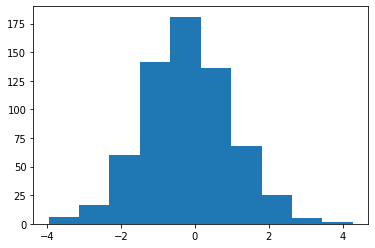

In [ ]:
# model = CNN()
# model = model.to(device=device)

with torch.no_grad():
    dl = splits["valid"]
    xb, yb = next(iter(dl))
    xb = xb.to(device=device)
    yb = yb.to(device=device)
    logits = model(xb)
    logits
    
    loss = torch.nn.functional.cross_entropy(logits, yb)
    
plt.hist(logits.to(device="cpu").flatten().detach());

print(logits.max(), logits.min(), logits.mean(), logits.std())

## Training

In [72]:
%%time

# model = CNN()
# model = model.to(device=device)
# model.train()

dl = splits["train"]
epoch = 2
i = 0
n = len(dl) * epoch

# metrics = []
# update_ratio = []
# optimizer = torch.optim.AdamW(model.parameters())

for _ in range(epoch):
    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 40 == 0:
            tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
            va_loss, va_acc = eval_split("valid", model, sample_size=1024)
            # update_ratio = [grad_ratio(p) for p in model.parameters() if p.dim() == 2]
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))
            print(f"{int(i/n*100)}%: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")
        
        i += 1
        optimizer.step()

0%: 0.35 0.46 0.89 0.85
2%: 0.32 0.46 0.90 0.85
5%: 0.31 0.49 0.90 0.85
7%: 0.40 0.52 0.87 0.83
10%: 0.37 0.50 0.88 0.84
13%: 0.37 0.48 0.87 0.85
15%: 0.40 0.58 0.90 0.85
18%: 0.32 0.49 0.90 0.84
20%: 0.41 0.51 0.88 0.84
23%: 0.35 0.46 0.89 0.85
26%: 0.32 0.47 0.90 0.86
28%: 0.38 0.47 0.86 0.86
31%: 0.32 0.45 0.89 0.86
33%: 0.32 0.49 0.89 0.84
36%: 0.29 0.44 0.90 0.87
39%: 0.29 0.43 0.90 0.86
41%: 0.32 0.45 0.90 0.86
44%: 0.35 0.45 0.92 0.85
46%: 0.30 0.43 0.90 0.87
49%: 0.32 0.51 0.88 0.86
52%: 0.29 0.46 0.91 0.87
54%: 0.31 0.51 0.89 0.85
57%: 0.33 0.57 0.90 0.84
60%: 0.29 0.56 0.90 0.85
62%: 0.27 0.43 0.90 0.86
65%: 0.28 0.48 0.90 0.86
67%: 0.31 0.48 0.90 0.86
70%: 0.27 0.43 0.92 0.87
73%: 0.33 0.42 0.89 0.87
75%: 0.26 0.41 0.92 0.86
78%: 0.28 0.46 0.92 0.87
80%: 0.32 0.46 0.91 0.86
83%: 0.29 0.44 0.92 0.85
86%: 0.32 0.45 0.90 0.85
88%: 0.24 0.45 0.93 0.86
91%: 0.28 0.52 0.91 0.86
93%: 0.25 0.40 0.93 0.86
96%: 0.24 0.43 0.92 0.88
99%: 0.26 0.43 0.91 0.86
CPU times: user 2min 11s, sys

In [73]:
tr_loss, tr_acc = eval_split("train", model)
va_loss, va_acc = eval_split("valid", model)

print(f"train: {tr_loss:.2f} {tr_acc:.2f}")
print(f"valid: {va_loss:.2f} {va_acc:.2f}")

train: 0.27 0.91
valid: 0.41 0.87


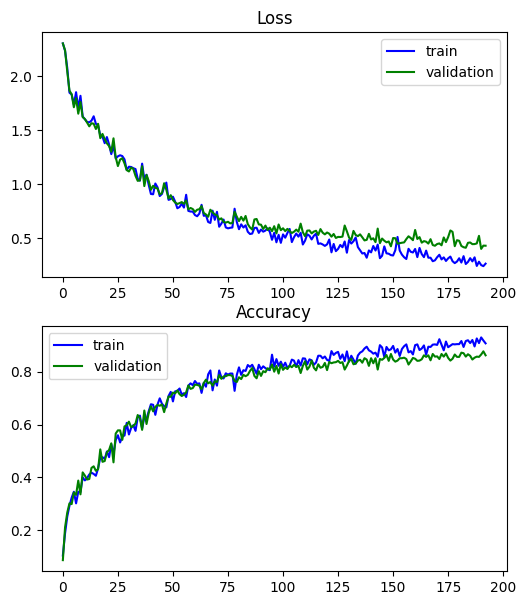

In [74]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)

plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plt.plot(tr_loss, label="train", color="b")
plt.plot(va_loss, label="validation", color="g")
plt.title("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tr_acc, label="train", color="b")
plt.plot(va_acc, label="validation", color="g")
plt.title("Accuracy")
plt.legend()

In [71]:
@torch.no_grad()
def predict(x):
    model.eval()
    x = x.to(device=device, dtype=dtype)
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    model.train()
    return yh

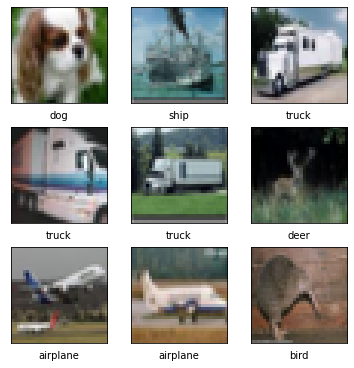

In [ ]:
xb, yb = next(iter(dl_valid))
pred = predict(xb)

plot_sample(xb, yb, pred)

In [75]:
eval_split("test", model)

(0.45819005370140076, 0.8542)

## Log


2 Layer ConvNet
```
conv(32, 3x3, p=1)
conv(32, 3x3, p=1)
fc(32768, 1024)
fc(1024, 10)
count: 33,575,850

train: 0.94 0.67
valid: 1.10 0.61
```

2 Layer ConvNet with better init
```
train: 0.88 0.70
valid: 1.16 0.60
```


3 Layer, 5 epoch
```
nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 32
nn.ReLU(),
nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # 32
nn.ReLU(),
nn.MaxPool2d(kernel_size=2, stride=2), # ((32 - 2) / 2) + 1 = 16
nn.Flatten(),
nn.Linear(128*16*16, 32*32),
nn.ReLU(),
nn.Linear(32*32, 10),

train: 0.05 0.99
valid: 1.53 0.66
```


3 Layer, 5 epoch, learning rate search (lr=0.0005, weight_decay=0.1)
```
train: 0.06 0.99
valid: 1.36 0.69
```



Small VGG
```
nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
nn.ReLU(),

nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
nn.ReLU(),

nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
nn.ReLU(),
nn.MaxPool2d(kernel_size=2, stride=2), # ((32 - 2) / 2) + 1 = 16

nn.Flatten(),
nn.Linear(256*16*16, 4096),
nn.ReLU(),
nn.Linear(4096, 1000),
nn.ReLU(),
nn.Linear(1000, 10),
parameter count: 273,757,762

train: 1.14 0.60
valid: 1.23 0.58
            
```


Small VGG With BN
```
nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
nn.ReLU(),

nn.BatchNorm2d(64),

nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
nn.ReLU(),

nn.BatchNorm2d(128),

nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
nn.ReLU(),
nn.Conv2d(in_channels=256, out_channels=256, kernel_size=1),
nn.ReLU(),
nn.MaxPool2d(kernel_size=2, stride=2), # ((32 - 2) / 2) + 1 = 16

nn.BatchNorm2d(256),

nn.Flatten(),
nn.Linear(256*16*16, 4096),
nn.ReLU(),
nn.Linear(4096, 1000),
nn.ReLU(),
nn.Linear(1000, 10),


train: 0.22 0.92
valid: 1.02 0.72
```

Smaller learning rate (lr=0.00001)

```
train: 0.01 1.00
valid: 1.30 0.64
```


With dropout
```
train: 0.31 0.90
valid: 0.79 0.75
```

Deeper, with data augmentation
```
train: 0.27 0.91
valid: 0.41 0.87
```